In [15]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0


In [20]:
import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11529835463050469731
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11232879659795556434
physical_device_desc: "device: XLA_CPU device"
]


In [2]:
from keras.layers import Input, Dense
from keras.models import Model

In [3]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [4]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [7]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11501568/11490434 [==============================] - 81s 7us/step


In [8]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

(60000, 784)
(10000, 784)


In [16]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.1030 - val_loss: 0.1012
Epoch 2/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.1027 - val_loss: 0.1009
Epoch 3/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1025 - val_loss: 0.1007
Epoch 4/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1022 - val_loss: 0.1005
Epoch 5/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1020 - val_loss: 0.1002
Epoch 6/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1018 - val_loss: 0.1000
Epoch 7/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1015 - val_loss: 0.0998
Epoch 8/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.1014 - val_loss: 0.0996
Epoch 9/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.1012 - val_loss: 0.0994
Epoch

In [10]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

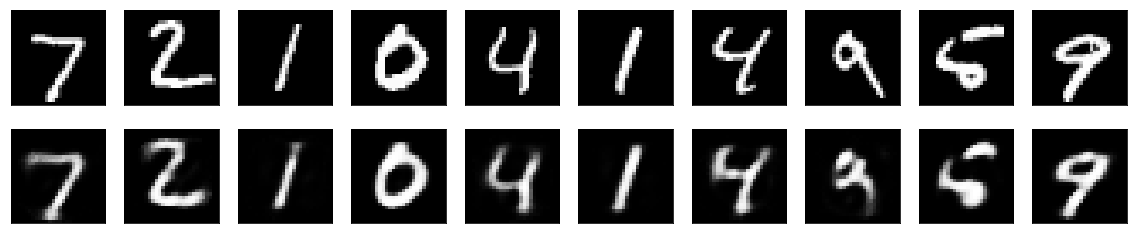

In [14]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()